In [1]:
year = None
month = None
program = "prepilot"
include_replaced_modes_as_valid = False # Flip this when we want to get results versus generate the replaced_mode correction graphs
input_dataset = "ONLY_SENSED" # "ONLY_LABELED", "ONLY_SENSED" or "BEST_AVAILABLE" for sensitivity analysis
LABEL_ASSIST_THRESHOLD = 0.3

In [2]:
import pandas as pd

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import scaffolding
from uuid import UUID

%matplotlib inline

URL not formatted, defaulting to "Stage_database"
Connecting to database URL db


### Load

In [3]:
def fix_minipilot_tokens():
    minipilot_uuid_list = [
        UUID("576e37c7-ab7e-4c03-add7-02486bc3f42e"),
        UUID("8b563348-52b3-4e3e-b046-a0aaf4fcea15"),
        UUID("5079bb93-c9cf-46d7-a643-dfc86bb05605"),
        UUID("feabfccd-dd6c-4e8e-8517-9d7177042483"),
        UUID("113aef67-400e-4e21-a29f-d04e50fc42ea"),
        UUID("c8b9fe22-86f8-449a-b64f-c18a8d20eefc"),
        UUID("e7b24d99-324d-4d6d-b247-9edc87d3c848"),
        UUID("1044195f-af9e-43d4-9407-60594e5e9938"),
        UUID("898b1a5e-cdd4-4a0c-90e4-942fa298e456"),
        UUID("1d292b85-c549-409a-a10d-746e957582a0"),
        UUID("cb3222a7-1e72-4a92-8b7b-2c4795402497"),
        UUID("efdbea3b-eef6-48fc-9558-7585f4ad6f24"),
        UUID("960835ac-9d8a-421d-8b8a-bf816f8a4b92"),
    ]
    for uuid in minipilot_uuid_list:
        curr_ue = edb.get_uuid_db().find_one({"uuid": uuid})
        curr_token = curr_ue["user_email"]
        if curr_token.split("_")[0] != "prepilot":
            curr_update_result = edb.get_uuid_db().update_one({"uuid": uuid}, {"$set": {"user_email": "prepilot_"+curr_token}})
            print("update result for %s is %s" % (uuid, curr_update_result.raw_result))

In [4]:
fix_minipilot_tokens()

update result for 576e37c7-ab7e-4c03-add7-02486bc3f42e is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for 8b563348-52b3-4e3e-b046-a0aaf4fcea15 is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for 5079bb93-c9cf-46d7-a643-dfc86bb05605 is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for feabfccd-dd6c-4e8e-8517-9d7177042483 is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for 113aef67-400e-4e21-a29f-d04e50fc42ea is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for c8b9fe22-86f8-449a-b64f-c18a8d20eefc is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for e7b24d99-324d-4d6d-b247-9edc87d3c848 is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for 1044195f-af9e-43d4-9407-60594e5e9938 is {'n': 1, 'nModified': 1, 'ok': 1.0, 'updatedExisting': True}
update result for 898b1a5e-cdd4-4a0c-90e4-942fa2

In [5]:
# Split UUIDs by program
program_uuid_map = {}
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    if program in program_uuid_map.keys():
        program_uuid_map[program].append(str(ue['uuid']))
    else:
        print(f"Found new program {program}, creating new list")
        program_uuid_map[program] = []
        program_uuid_map[program].append(str(ue['uuid']))

Found new program stage, creating new list
Found new program 4c, creating new list
Found new program cc, creating new list
Found new program fc, creating new list
Found new program pc, creating new list
Found new program sc, creating new list
Found new program vail, creating new list
Found new program prepilot, creating new list


In [6]:
uuid_program_list = []
for ue in edb.get_uuid_db().find():
    program = ue['user_email'].split("_")[0]
    uuid_program_list.append({"program": program, "opcode": ue["user_email"], "user_id_str": str(ue['uuid'])})

In [7]:
program_uuid_map.keys()

dict_keys(['stage', '4c', 'cc', 'fc', 'pc', 'sc', 'vail', 'prepilot'])

In [8]:
uuid_program_df = pd.DataFrame.from_dict(uuid_program_list)
uuid_program_df.head()

,program,opcode,user_id_str
0,stage,stage_-o7_9mpIOG0,2bc8ca71-7d0f-4930-ba2c-cf97f7dceaea
1,stage,stage_HiPajVSJhsc,b0c98c51-4bb9-4c67-9ec3-7814cfbdfc82
2,stage,stage_9fVPYzQDo6Q,d4376620-fbcd-4aab-95bf-8c2e0ecf9adf
3,stage,stage_qaFAEe8DY7k,802667b6-371f-45b2-9c7a-bb051244836a
4,stage,stage_rDuumFma4Ao,1fdbfb17-5168-445a-8c2b-14efd528ccdd


In [9]:
uuid_program_df.loc[uuid_program_df.groupby("program").groups['4c']]

,program,opcode,user_id_str
88,4c,4c_Ze5Y_li7r4MOsbqj,863e9c6c-8ec0-48c4-b765-3f73d839c85b
89,4c,4c_AGgrHoywg5gYmyL8,c6e4db31-c18b-4355-b02a-7dd97deca70b
90,4c,4c_Ri332Xj3DKaCrdwl,c6807997-194c-4c52-8a8f-a8c1f6ee1595
91,4c,4c_6gzfgbVUODrbTdc_,e9e479e9-5c3f-4345-a885-dadb7999b312
92,4c,4c_eJEIg2mWQYU3ISXU,6656c04c-6cba-4c18-9fed-805eaa529741
93,4c,4c_s7jHZr7a0yQOAa1b,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d
94,4c,4c_zo3s-4h_XC9SWygF,9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98
95,4c,4c_rsW7GeiQJR3HVBby,509b9093-9093-4e98-8eb1-20b58ed9bd8c
96,4c,4c_rjfwBKd_E-LDrcGU,e192b8a0-0b6c-4222-9685-1c93785deaf7
97,4c,4c_7gkYfJJBJlb4Iat1,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d


In [10]:
program_uuid_map['4c']

['863e9c6c-8ec0-48c4-b765-3f73d839c85b',
 'c6e4db31-c18b-4355-b02a-7dd97deca70b',
 'c6807997-194c-4c52-8a8f-a8c1f6ee1595',
 'e9e479e9-5c3f-4345-a885-dadb7999b312',
 '6656c04c-6cba-4c18-9fed-805eaa529741',
 '9910245f-ee4e-4cca-ab4c-dd2312eb0d5d',
 '9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98',
 '509b9093-9093-4e98-8eb1-20b58ed9bd8c',
 'e192b8a0-0b6c-4222-9685-1c93785deaf7',
 '2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d',
 '56e23e21-6152-4f59-9253-50bd28a5d7f9',
 '840297ae-3948-4e26-bfeb-e83ee30c5b3e',
 'd7a732f4-a864-4bcb-b8de-dfc8be242fb2',
 '5ad862e7-9a63-41f6-9f28-c0096fe884da',
 '21c78a1c-6df2-4097-b289-5a784610991b',
 'e4cfb2a8-f600-4268-9756-9985e234636e']

In [11]:
tq = scaffolding.get_time_query(year, month)
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)

0      stage_-o7_9mpIOG0
1      stage_HiPajVSJhsc
2      stage_9fVPYzQDo6Q
3      stage_qaFAEe8DY7k
4      stage_rDuumFma4Ao
             ...        
279    prepilot_rhBZukxY
280    prepilot_k36cxmfA
281    prepilot_FmxVf8u6
282    prepilot_pNpK4pFg
283    prepilot_F3jxHLSW
Name: user_email, Length: 284, dtype: object

Loaded all confirmed trips of length 241123


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.629238e+09,2021-08-17T18:02:26.493017-04:00,"{'type': 'Point', 'coordinates': [-71.08788681...",611c350df3bfdd5663c34e52,1.629237e+09,2021-08-17T17:51:32.998732-04:00,"{'type': 'Point', 'coordinates': [-71.11831245...",653.494285,2700.231495,...,8,17,18,2,26,1,America/New_York,611fdd6f1c25a2c3dbf7c5be,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.629478e+09
1,DwellSegmentationTimeFilter,1.628682e+09,2021-08-11T13:39:44.936000+02:00,"{'type': 'Point', 'coordinates': [33.7674264, ...",6113bf6009f3390d387bb211,1.628682e+09,2021-08-11T13:33:51+02:00,"{'type': 'Point', 'coordinates': [33.7754756, ...",353.936000,1368.259843,...,8,11,13,39,44,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cb,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09
2,DwellSegmentationTimeFilter,1.628684e+09,2021-08-11T14:06:11.774000+02:00,"{'type': 'Point', 'coordinates': [33.7595711, ...",6113cd7024f71bcfb27d7c5d,1.628682e+09,2021-08-11T13:42:44.936000+02:00,"{'type': 'Point', 'coordinates': [33.7674264, ...",1406.838000,944.948370,...,8,11,14,6,11,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cc,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09
3,DwellSegmentationTimeFilter,1.628686e+09,2021-08-11T14:49:37.923000+02:00,"{'type': 'Point', 'coordinates': [33.7673488, ...",6113cd7024f71bcfb27d7c5f,1.628684e+09,2021-08-11T14:09:11.774000+02:00,"{'type': 'Point', 'coordinates': [33.7595711, ...",2426.149000,935.565727,...,8,11,14,49,37,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cd,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09
4,DwellSegmentationTimeFilter,1.628688e+09,2021-08-11T15:11:54.772000+02:00,"{'type': 'Point', 'coordinates': [33.7643828, ...",6114ca95c783b3519ce45faa,1.628687e+09,2021-08-11T15:05:28.344737+02:00,"{'type': 'Point', 'coordinates': [33.7673488, ...",386.427263,1398.167487,...,8,11,15,11,54,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116ce,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09


After filtering, found 241123 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.629238e+09,2021-08-17T18:02:26.493017-04:00,"{'type': 'Point', 'coordinates': [-71.08788681...",611c350df3bfdd5663c34e52,1.629237e+09,2021-08-17T17:51:32.998732-04:00,"{'type': 'Point', 'coordinates': [-71.11831245...",653.494285,2700.231495,...,8,17,18,2,26,1,America/New_York,611fdd6f1c25a2c3dbf7c5be,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.629478e+09
1,DwellSegmentationTimeFilter,1.628682e+09,2021-08-11T13:39:44.936000+02:00,"{'type': 'Point', 'coordinates': [33.7674264, ...",6113bf6009f3390d387bb211,1.628682e+09,2021-08-11T13:33:51+02:00,"{'type': 'Point', 'coordinates': [33.7754756, ...",353.936000,1368.259843,...,8,11,13,39,44,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cb,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09
2,DwellSegmentationTimeFilter,1.628684e+09,2021-08-11T14:06:11.774000+02:00,"{'type': 'Point', 'coordinates': [33.7595711, ...",6113cd7024f71bcfb27d7c5d,1.628682e+09,2021-08-11T13:42:44.936000+02:00,"{'type': 'Point', 'coordinates': [33.7674264, ...",1406.838000,944.948370,...,8,11,14,6,11,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cc,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09
3,DwellSegmentationTimeFilter,1.628686e+09,2021-08-11T14:49:37.923000+02:00,"{'type': 'Point', 'coordinates': [33.7673488, ...",6113cd7024f71bcfb27d7c5f,1.628684e+09,2021-08-11T14:09:11.774000+02:00,"{'type': 'Point', 'coordinates': [33.7595711, ...",2426.149000,935.565727,...,8,11,14,49,37,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116cd,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09
4,DwellSegmentationTimeFilter,1.628688e+09,2021-08-11T15:11:54.772000+02:00,"{'type': 'Point', 'coordinates': [33.7643828, ...",6114ca95c783b3519ce45faa,1.628687e+09,2021-08-11T15:05:28.344737+02:00,"{'type': 'Point', 'coordinates': [33.7673488, ...",386.427263,1398.167487,...,8,11,15,11,54,2,Africa/Blantyre,611fdd6fbc8ce4a9e39116ce,0a093cbd-b536-43af-b03d-293425e84c76,1.629478e+09


In [12]:
participant_ct_df["user_id_str"] = participant_ct_df.user_id.apply(lambda u: str(u))
len(participant_ct_df.user_id_str.unique())

261

### Transform

In [13]:
trip_program_df = participant_ct_df.merge(uuid_program_df, on="user_id_str")

In [14]:
trip_program_df.sample(n=50, random_state=123)[["program", "user_id_str", "opcode", "_id", "start_fmt_time", "end_fmt_time"]]

,program,user_id_str,opcode,_id,start_fmt_time,end_fmt_time
22521,stage,f2799dc2-02bc-4249-b42a-4fda8770d1b6,stage_4UdVIDrMwsY,611fdf0c1c25a2c3dbf7fcbb,2021-07-22T08:36:58.268567-06:00,2021-07-22T08:44:10.993490-06:00
218295,sc,b36f7b55-65a3-40d8-aa97-0590bfb14782,sc_E5PfmGptjL24Si3Y,6131f5dcb5d25d31385f2e66,2021-09-02T22:28:56.132556-06:00,2021-09-02T22:37:50-06:00
10574,stage,cde34edb-8e3a-4278-a18e-0adb062999e5,stage_LNW-QhfTBT0,616b8818d1a6f144bef8fd4b,2021-10-16T18:14:47.639390-07:00,2021-10-16T18:23:33.802000-07:00
195669,pc,7559c3f8-80f3-41e8-98a4-02eba96a855d,pc_-i66Ai1L5J6NWfht,625635771efa5e67f913e927,2022-04-12T19:12:12.983113-06:00,2022-04-12T19:35:04.922641-06:00
222531,sc,f0db3b19-99c2-410b-a593-3103eca9212f,sc_bJChhTr2wFT7aKzx,61c3157a4f02266ad8795dce,2021-07-14T00:25:44.512472-06:00,2021-07-14T01:04:13.810000-06:00
70059,cc,03a395b4-d861-4757-bb84-32b4984559b0,cc_WemE_5WkFUaLPmuf,62041633ed76c7646dde479d,2022-02-09T12:05:36.172810-07:00,2022-02-09T12:13:36.345554-07:00
111111,cc,8a8332a5-3a1b-4cdd-9f36-80434e91a6ef,cc_8NEItWshwpYh46sP,61c55ac20f3ab5ea32ef47b3,2021-12-23T19:11:07.797946-07:00,2021-12-23T19:29:39.767171-07:00
149432,fc,487ad897-ba93-404a-8cbe-5de7d1922691,fc_csu_Tm3oQ7KqlhllQt8M,6252154c3aa4b586467cc0ea,2022-04-09T16:59:47.637347-06:00,2022-04-09T17:14:19.671000-06:00
11608,stage,29d04974-ff70-4c61-a0b0-dafcc1d23ec8,stage_Mhg6TUJR-J4,611fddfbbc8ce4a9e391264e,2021-04-21T15:14:27.576497-07:00,2021-04-21T15:28:45.999978-07:00
167771,pc,321b7e37-a9a1-4775-9ebb-b5dc88e183fb,pc_kWS5HwcP2T9163-R,623aa0204c06612246ca28ae,2022-03-22T21:03:26.996659-06:00,2022-03-22T21:35:09-06:00


In [15]:
labeled_ct = scaffolding.filter_labeled_trips(trip_program_df)

After filtering, found 92446 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,program,opcode
0,DwellSegmentationDistFilter,1.629238e+09,2021-08-17T18:02:26.493017-04:00,"{'type': 'Point', 'coordinates': [-71.08788681...",611c350df3bfdd5663c34e52,1.629237e+09,2021-08-17T17:51:32.998732-04:00,"{'type': 'Point', 'coordinates': [-71.11831245...",653.494285,2700.231495,...,2,26,1,America/New_York,611fdd6f1c25a2c3dbf7c5be,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.629478e+09,8a0473ca-e53d-4720-a99c-0696cc1fb407,stage,stage_Gsj79JeJWF4
21,DwellSegmentationDistFilter,1.645386e+09,2022-02-20T12:32:43.451677-07:00,"{'type': 'Point', 'coordinates': [-111.9450490...",6212ce379106a670c421b888,1.645383e+09,2022-02-20T11:58:02.051102-07:00,"{'type': 'Point', 'coordinates': [-111.9167906...",2081.400574,18093.352854,...,32,43,6,America/Phoenix,6212ce599106a670c421b98b,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.645400e+09,8a0473ca-e53d-4720-a99c-0696cc1fb407,stage,stage_Gsj79JeJWF4
23,DwellSegmentationDistFilter,1.645391e+09,2022-02-20T14:07:17.998778-07:00,"{'type': 'Point', 'coordinates': [-111.9440840...",6212ce459106a670c421b88c,1.645388e+09,2022-02-20T13:20:30.462982-07:00,"{'type': 'Point', 'coordinates': [-111.9437005...",2807.535796,984.681194,...,7,17,6,America/Phoenix,6212ce599106a670c421b98d,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.645400e+09,8a0473ca-e53d-4720-a99c-0696cc1fb407,stage,stage_Gsj79JeJWF4
24,DwellSegmentationDistFilter,1.645397e+09,2022-02-20T15:35:51.018136-07:00,"{'type': 'Point', 'coordinates': [-111.9448744...",6212ce459106a670c421b88e,1.645397e+09,2022-02-20T15:35:16.506669-07:00,"{'type': 'Point', 'coordinates': [-111.9440840...",34.511467,183.932256,...,35,51,6,America/Phoenix,6212ce599106a670c421b98e,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.645400e+09,8a0473ca-e53d-4720-a99c-0696cc1fb407,stage,stage_Gsj79JeJWF4
25,DwellSegmentationDistFilter,1.645405e+09,2022-02-20T17:52:13.000176-07:00,"{'type': 'Point', 'coordinates': [-110.8175686...",6214032d39cfe183d0343a07,1.645397e+09,2022-02-20T15:43:38.468902-07:00,"{'type': 'Point', 'coordinates': [-111.9448744...",7714.531274,192258.374492,...,52,13,6,America/Phoenix,621404a139cfe183d0343c23,8a0473ca-e53d-4720-a99c-0696cc1fb407,1.645479e+09,8a0473ca-e53d-4720-a99c-0696cc1fb407,stage,stage_Gsj79JeJWF4


In [16]:
label_summary_df = pd.DataFrame({"total_trips": trip_program_df.groupby("program").source.count(), "labeled_trips": labeled_ct.groupby("program").source.count()})
label_summary_df

,total_trips,labeled_trips
program,,
4c,14417,5268
cc,75184,28834
fc,32429,11751
pc,51182,17889
prepilot,3492,2425
sc,17984,9096
stage,37302,10827
vail,9133,6356


In [17]:
label_summary_df["label_pct"] = (label_summary_df.labeled_trips / label_summary_df.total_trips) * 100

In [18]:
label_summary_df

,total_trips,labeled_trips,label_pct
program,,,
4c,14417,5268,36.540196
cc,75184,28834,38.351245
fc,32429,11751,36.236085
pc,51182,17889,34.951741
prepilot,3492,2425,69.444444
sc,17984,9096,50.578292
stage,37302,10827,29.025253
vail,9133,6356,69.593781


In [19]:
label_user_summary_df = pd.DataFrame({"total_trips": trip_program_df.groupby(["program", "user_id_str"]).source.count(), "labeled_trips": labeled_ct.groupby(["program", "user_id_str"]).source.count()})

In [20]:
label_user_summary_df["label_pct"] = (label_user_summary_df.labeled_trips / label_user_summary_df.total_trips) * 100
label_user_summary_df

total_trips  labeled_trips  \
program user_id_str                                                        
4c      2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d          383          155.0   
        509b9093-9093-4e98-8eb1-20b58ed9bd8c          389          298.0   
        56e23e21-6152-4f59-9253-50bd28a5d7f9         1717          812.0   
        5ad862e7-9a63-41f6-9f28-c0096fe884da         2558          674.0   
        6656c04c-6cba-4c18-9fed-805eaa529741         1296          117.0   
...                                                   ...            ...   
vail    dfe5ca1b-b085-4b67-a6ff-ccad9565d669          259          244.0   
        e0db410c-dac4-4647-afc0-6aa055477352          396           42.0   
        eb2e2a52-1156-4a92-90fc-b06032f9b4af          611          593.0   
        f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0         1290          565.0   
        fc8f71a3-8c82-458d-bf97-18c3ee11a0f3         1080         1075.0   

                                              label_pct  
program user_id_str                                      
4c      2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d  40.469974  
        509b9093-9093-4e98-8eb1-20b58ed9bd8c  76.606684  
        56e23e21-6152-4f59-9253-50bd28a5d7f9  47.291788  
        5ad862e7-9a63-41f6-9f28-c0096fe884da  26.348710  
        6656c04c-6cba-4c18-9fed-805eaa529741   9.027778  
...                                                 ...  
vail    dfe5ca1b-b085-4b67-a6ff-ccad9565d669  94.208494  
        e0db410c-dac4-4647-afc0-6aa055477352  10.606061  
        eb2e2a52-1156-4a92-90fc-b06032f9b4af  97.054010  
        f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0  43.798450  
        fc8f71a3-8c82-458d-bf97-18c3ee11a0f3  99.537037  

[261 rows x 3 columns]

In [21]:
label_summary_df.drop("prepilot")

,total_trips,labeled_trips,label_pct
program,,,
4c,14417,5268,36.540196
cc,75184,28834,38.351245
fc,32429,11751,36.236085
pc,51182,17889,34.951741
sc,17984,9096,50.578292
stage,37302,10827,29.025253
vail,9133,6356,69.593781


In [22]:
label_user_summary_df.drop("prepilot")

/root/miniconda-4.12.0/envs/emission/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


total_trips  labeled_trips  \
program user_id_str                                                        
4c      2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d          383          155.0   
        509b9093-9093-4e98-8eb1-20b58ed9bd8c          389          298.0   
        56e23e21-6152-4f59-9253-50bd28a5d7f9         1717          812.0   
        5ad862e7-9a63-41f6-9f28-c0096fe884da         2558          674.0   
        6656c04c-6cba-4c18-9fed-805eaa529741         1296          117.0   
...                                                   ...            ...   
vail    dfe5ca1b-b085-4b67-a6ff-ccad9565d669          259          244.0   
        e0db410c-dac4-4647-afc0-6aa055477352          396           42.0   
        eb2e2a52-1156-4a92-90fc-b06032f9b4af          611          593.0   
        f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0         1290          565.0   
        fc8f71a3-8c82-458d-bf97-18c3ee11a0f3         1080         1075.0   

                                              label_pct  
program user_id_str                                      
4c      2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d  40.469974  
        509b9093-9093-4e98-8eb1-20b58ed9bd8c  76.606684  
        56e23e21-6152-4f59-9253-50bd28a5d7f9  47.291788  
        5ad862e7-9a63-41f6-9f28-c0096fe884da  26.348710  
        6656c04c-6cba-4c18-9fed-805eaa529741   9.027778  
...                                                 ...  
vail    dfe5ca1b-b085-4b67-a6ff-ccad9565d669  94.208494  
        e0db410c-dac4-4647-afc0-6aa055477352  10.606061  
        eb2e2a52-1156-4a92-90fc-b06032f9b4af  97.054010  
        f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0  43.798450  
        fc8f71a3-8c82-458d-bf97-18c3ee11a0f3  99.537037  

[248 rows x 3 columns]

### Plot

<AxesSubplot:title={'center':'Variation in labeling percentage across programs'}, xlabel='program', ylabel='% of labeled trips'>

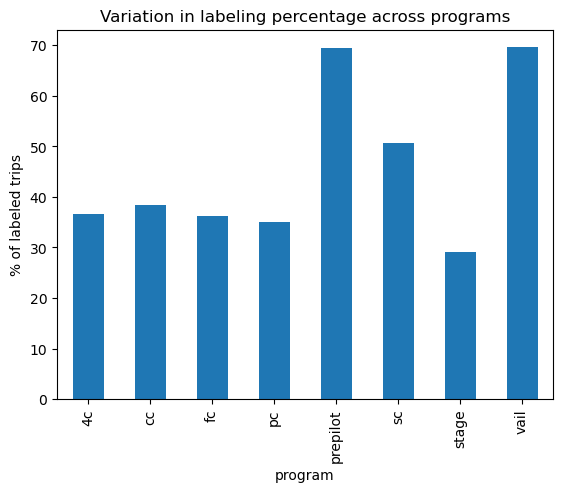

In [23]:
label_summary_df.label_pct.plot(kind="bar", ylabel="% of labeled trips", title="Variation in labeling percentage across programs")

<AxesSubplot:title={'center':'Variation in labeling percentage across programs'}, xlabel='program', ylabel='% of labeled trips'>

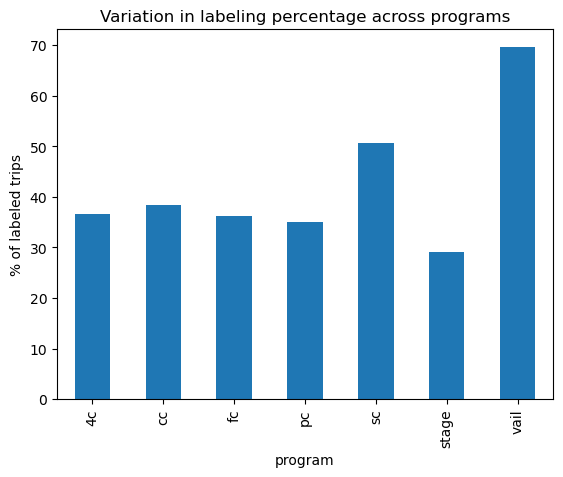

In [24]:
label_summary_df.drop("prepilot").label_pct.plot(kind="bar", ylabel="% of labeled trips", title="Variation in labeling percentage across programs")

Text(0.5, 1.0, 'Percentage of trips labeled by each user')

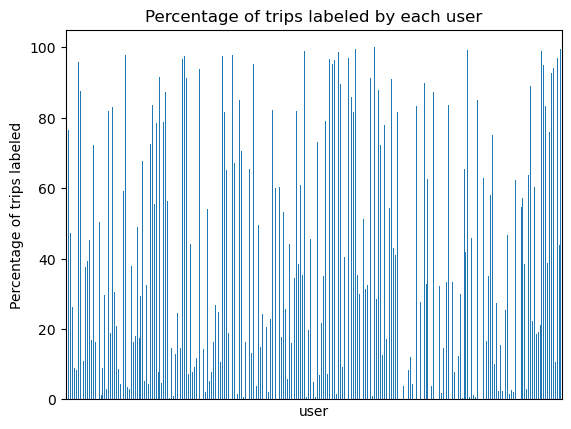

In [25]:
ax=label_user_summary_df.label_pct.plot(kind="bar", xticks=[])
ax.set_xlabel("user")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Percentage of trips labeled by each user")

/root/miniconda-4.12.0/envs/emission/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Text(0.5, 1.0, 'Percentage of trips labeled by each user')

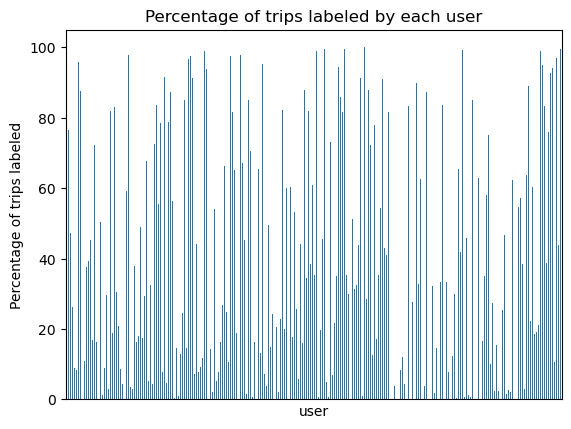

In [26]:
ax=label_user_summary_df.drop("prepilot").label_pct.plot(kind="bar", xticks=[])
ax.set_xlabel("user")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Percentage of trips labeled by each user")

In [27]:
flattened_label_user_summary_df = label_user_summary_df.reset_index()

In [28]:
flattened_label_user_summary_df

,program,user_id_str,total_trips,labeled_trips,label_pct
0,4c,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,383,155.0,40.469974
1,4c,509b9093-9093-4e98-8eb1-20b58ed9bd8c,389,298.0,76.606684
2,4c,56e23e21-6152-4f59-9253-50bd28a5d7f9,1717,812.0,47.291788
3,4c,5ad862e7-9a63-41f6-9f28-c0096fe884da,2558,674.0,26.348710
4,4c,6656c04c-6cba-4c18-9fed-805eaa529741,1296,117.0,9.027778
...,...,...,...,...,...
256,vail,dfe5ca1b-b085-4b67-a6ff-ccad9565d669,259,244.0,94.208494
257,vail,e0db410c-dac4-4647-afc0-6aa055477352,396,42.0,10.606061
258,vail,eb2e2a52-1156-4a92-90fc-b06032f9b4af,611,593.0,97.054010
259,vail,f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0,1290,565.0,43.798450


In [29]:
no_prepilot_flattened_label_user_summary_df = label_user_summary_df.drop("prepilot").reset_index()

/root/miniconda-4.12.0/envs/emission/lib/python3.7/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [30]:
no_prepilot_flattened_label_user_summary_df

,program,user_id_str,total_trips,labeled_trips,label_pct
0,4c,2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d,383,155.0,40.469974
1,4c,509b9093-9093-4e98-8eb1-20b58ed9bd8c,389,298.0,76.606684
2,4c,56e23e21-6152-4f59-9253-50bd28a5d7f9,1717,812.0,47.291788
3,4c,5ad862e7-9a63-41f6-9f28-c0096fe884da,2558,674.0,26.348710
4,4c,6656c04c-6cba-4c18-9fed-805eaa529741,1296,117.0,9.027778
...,...,...,...,...,...
243,vail,dfe5ca1b-b085-4b67-a6ff-ccad9565d669,259,244.0,94.208494
244,vail,e0db410c-dac4-4647-afc0-6aa055477352,396,42.0,10.606061
245,vail,eb2e2a52-1156-4a92-90fc-b06032f9b4af,611,593.0,97.054010
246,vail,f446bf31-02ff-4bd9-9ea1-c98f7d2f7af0,1290,565.0,43.798450


Text(0.5, 0.98, 'Labeling rate by program')

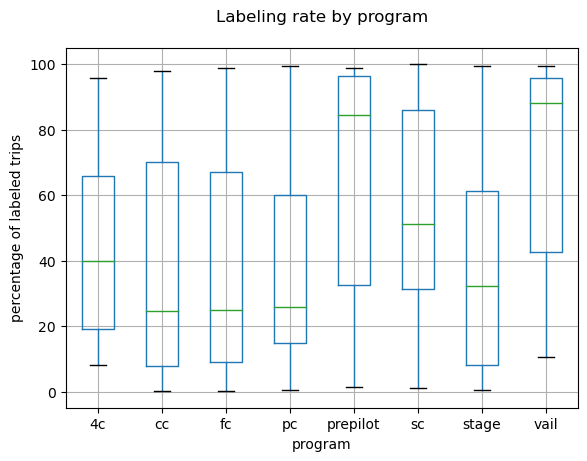

In [31]:
ax = flattened_label_user_summary_df.boxplot(column=['label_pct'], by="program")
type(ax)
ax.set_title("")
ax.set_ylabel("percentage of labeled trips")
ax.get_figure().suptitle("Labeling rate by program")

Text(0.5, 0.98, 'Labeling rate by program')

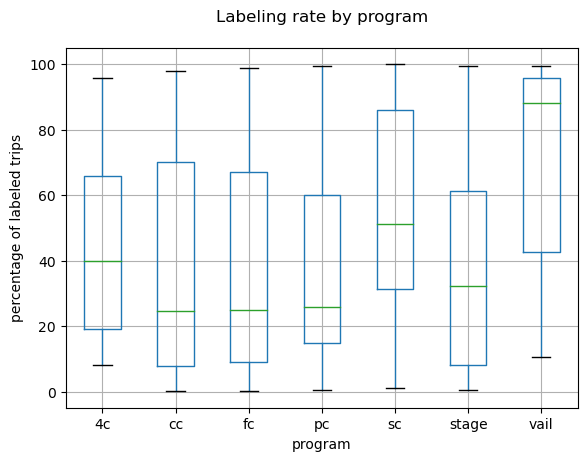

In [32]:
ax = no_prepilot_flattened_label_user_summary_df.boxplot(column=['label_pct'], by="program")
type(ax)
ax.set_title("")
ax.set_ylabel("percentage of labeled trips")
ax.get_figure().suptitle("Labeling rate by program")

Text(0.5, 1.0, 'Percentage of trips labeled by user')

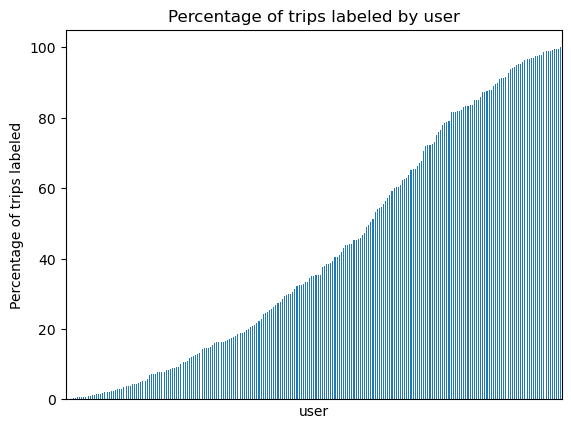

In [33]:
ax = flattened_label_user_summary_df.dropna().sort_values(by="label_pct").label_pct.plot.bar(y="label_pct", xticks=[])
ax.set_xlabel("user")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Percentage of trips labeled by user")

Text(0.5, 1.0, 'Percentage of trips labeled by user')

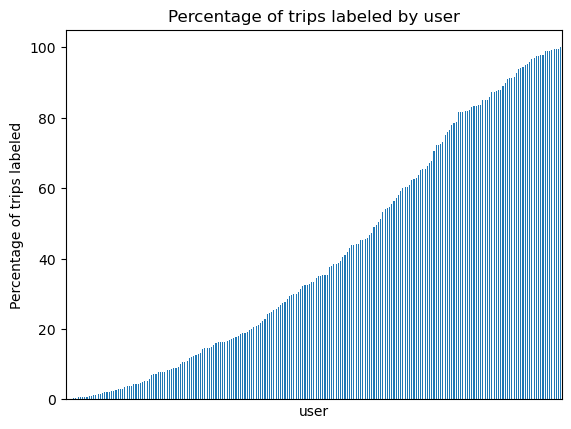

In [34]:
ax = no_prepilot_flattened_label_user_summary_df.dropna().sort_values(by="label_pct").label_pct.plot.bar(y="label_pct", xticks=[])
ax.set_xlabel("user")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Percentage of trips labeled by user")

In [35]:
import seaborn as sns

Text(0.5, 1.0, 'Mean labeling rate and variance per program')

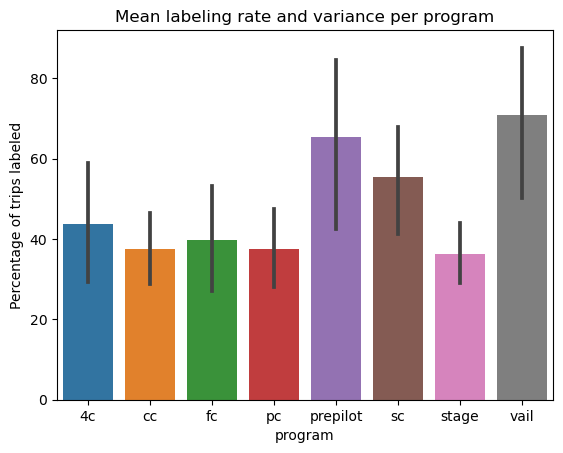

In [36]:
ax=sns.barplot(data=flattened_label_user_summary_df, x="program", y="label_pct")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Mean labeling rate and variance per program")

Text(0.5, 1.0, 'Mean labeling rate and variance per program')

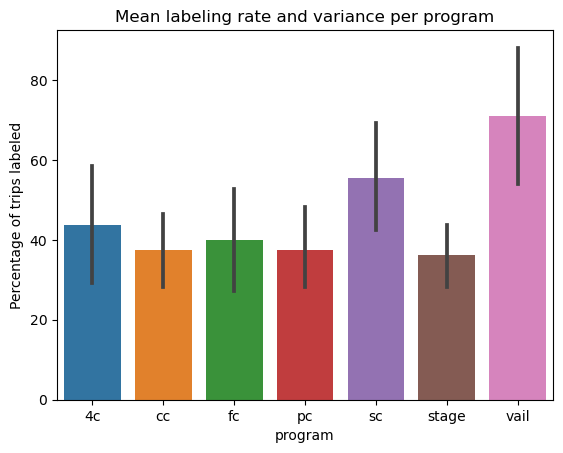

In [37]:
ax=sns.barplot(data=no_prepilot_flattened_label_user_summary_df, x="program", y="label_pct")
ax.set_ylabel("Percentage of trips labeled")
ax.set_title("Mean labeling rate and variance per program")

### Describe

In [38]:
def describe_label_info(df):
    print(f"Total number of trips {len(df)} from {len(df.user_id.unique())} unique users")
    print(f"Number of trips with at least one label {len(df[df.user_input != {}])} from {len(df[df.user_input != {}].user_id.unique())} unique users")
    no_user_label_ct_df = df[df.user_input == {}]
    print(f"Trips without user specified labels {len(no_user_label_ct_df)} from {len(no_user_label_ct_df.user_id.unique())} users")
    is_empty_check = lambda ll: len(ll) == 0 if type(ll) == list else True
    print(f"Trips without user label but with inferred label {len(no_user_label_ct_df[~no_user_label_ct_df.inferred_labels.apply(is_empty_check)])}")
    print(f"Trips without user label or inferred label {len(no_user_label_ct_df[no_user_label_ct_df.inferred_labels.apply(is_empty_check)])}")
    stage_df = df[df.program == 'stage']
    print(f"Number of trips in stage = {len(df[df.program=='stage'])} from {len(df[df.program=='stage'].user_id.unique())} unique users")
    print(f"Number of trips in real programs = {len(df[df.program!='stage'])} from {len(df[df.program!='stage'].user_id.unique())} unique users")
    trip_count_df = df.groupby("program").source.count()
    user_count_df = df.groupby("program").user_id.unique().apply(lambda unique_list: len(unique_list))
    # print(trip_count_df)
    # print(user_count_df)
    count_df = pd.DataFrame({"trips": trip_count_df, "unique_users": user_count_df})
    # print(count_df)
    print(f"Program specific counts: ", count_df.to_dict())

In [39]:
# test_df = pd.DataFrame({"inferred_labels": [[], np.NaN, [1,2], [3.4]]})

In [40]:
# test_df

In [41]:
# is_empty_check = lambda ll: len(ll) == 0 if type(ll) == list else True
# test_df.inferred_labels.apply(is_empty_check)

In [42]:
describe_label_info(trip_program_df)

Total number of trips 241123 from 261 unique users
Number of trips with at least one label 92446 from 235 unique users
Trips without user specified labels 148677 from 260 users
Trips without user label but with inferred label 43404
Trips without user label or inferred label 105273
Number of trips in stage = 37302 from 78 unique users
Number of trips in real programs = 203821 from 183 unique users
Program specific counts:  {'trips': {'4c': 14417, 'cc': 75184, 'fc': 32429, 'pc': 51182, 'prepilot': 3492, 'sc': 17984, 'stage': 37302, 'vail': 9133}, 'unique_users': {'4c': 15, 'cc': 52, 'fc': 30, 'pc': 39, 'prepilot': 13, 'sc': 22, 'stage': 78, 'vail': 12}}


In [43]:
describe_label_info(trip_program_df[trip_program_df.program != "prepilot"])

Total number of trips 237631 from 248 unique users
Number of trips with at least one label 90021 from 223 unique users
Trips without user specified labels 147610 from 247 users
Trips without user label but with inferred label 43404
Trips without user label or inferred label 104206
Number of trips in stage = 37302 from 78 unique users
Number of trips in real programs = 200329 from 170 unique users
Program specific counts:  {'trips': {'4c': 14417, 'cc': 75184, 'fc': 32429, 'pc': 51182, 'sc': 17984, 'stage': 37302, 'vail': 9133}, 'unique_users': {'4c': 15, 'cc': 52, 'fc': 30, 'pc': 39, 'sc': 22, 'stage': 78, 'vail': 12}}


In [44]:
describe_label_info(labeled_ct)

Total number of trips 92446 from 235 unique users
Number of trips with at least one label 92446 from 235 unique users
Trips without user specified labels 0 from 0 users
Trips without user label but with inferred label 0
Trips without user label or inferred label 0
Number of trips in stage = 10827 from 59 unique users
Number of trips in real programs = 81619 from 176 unique users
Program specific counts:  {'trips': {'4c': 5268, 'cc': 28834, 'fc': 11751, 'pc': 17889, 'prepilot': 2425, 'sc': 9096, 'stage': 10827, 'vail': 6356}, 'unique_users': {'4c': 14, 'cc': 51, 'fc': 29, 'pc': 37, 'prepilot': 12, 'sc': 21, 'stage': 59, 'vail': 12}}


In [45]:
describe_label_info(labeled_ct[labeled_ct.program != "prepilot"])

Total number of trips 90021 from 223 unique users
Number of trips with at least one label 90021 from 223 unique users
Trips without user specified labels 0 from 0 users
Trips without user label but with inferred label 0
Trips without user label or inferred label 0
Number of trips in stage = 10827 from 59 unique users
Number of trips in real programs = 79194 from 164 unique users
Program specific counts:  {'trips': {'4c': 5268, 'cc': 28834, 'fc': 11751, 'pc': 17889, 'sc': 9096, 'stage': 10827, 'vail': 6356}, 'unique_users': {'4c': 14, 'cc': 51, 'fc': 29, 'pc': 37, 'sc': 21, 'stage': 59, 'vail': 12}}


In [46]:
# Android versions

In [47]:
profile_df = pd.json_normalize(edb.get_profile_db().find())
profile_df["user_id_str"] = profile_df.user_id.apply(lambda u: str(u))
profile_program_df = profile_df.merge(uuid_program_df, on="user_id_str")

<AxesSubplot:ylabel='client_os_version'>

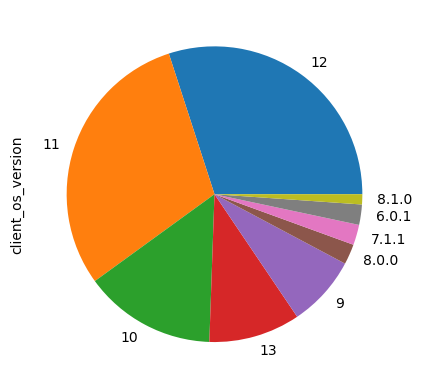

In [48]:
profile_program_df.query("curr_platform == 'android' & program != 'stage'").client_os_version.value_counts().plot(kind='pie')

<AxesSubplot:ylabel='client_os_version'>

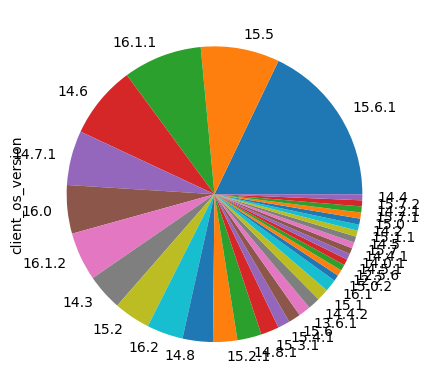

In [49]:
profile_program_df.query("curr_platform == 'ios'").client_os_version.value_counts().plot(kind='pie')

<AxesSubplot:ylabel='client_os_version'>

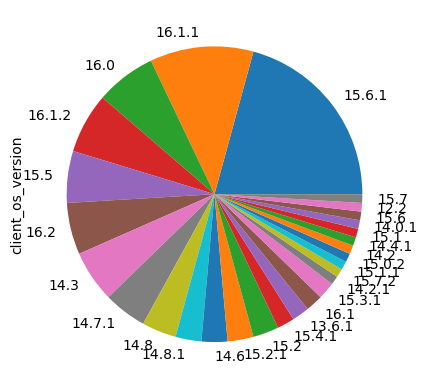

In [50]:
profile_program_df.query("curr_platform == 'ios' & program != 'stage'").client_os_version.value_counts().plot(kind='pie')

In [51]:
high_income_participants = [...]
uuid_program_df[uuid_program_df.user_id_str.isin(high_income_participants)]

,program,opcode,user_id_str


In [52]:
participant_ct_df["start_ts_dt"] = participant_ct_df.start_ts.apply(lambda st: arrow.get(st))

NameError: name 'arrow' is not defined

In [ ]:
participant_ct_df[participant_ct_df.user_id_str.isin(high_income_participants)].groupby("user_id_str").start_ts_dt.min()

In [ ]:
participant_ct_df[participant_ct_df.user_id_str.isin(high_income_participants)].groupby("user_id_str").start_ts_dt.max()

In [ ]:
participant_ct_df[participant_ct_df.user_id_str.isin(high_income_participants)].groupby('user_id_str').plot(x="start_ts_dt", y="distance", subplots=True)

In [ ]:
en_survey = pd.read_csv("en_survey.csv")

In [ ]:
def convert_to_uuid_format(us):
    try:
        return str(UUID(us))
    except ValueError as e:
        return None
    
en_survey["user_id_str"] = en_survey['Unique User ID (auto-filled, do not edit)'].dropna().apply(convert_to_uuid_format)

In [ ]:
en_survey[en_survey.user_id_str.isin(high_income_participants)]